In [1]:
# Import libraries
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pandas as pd, pickle
import random
from random import seed, random, randint, sample

import tensorflow.keras as keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, GlobalMaxPool1D, Activation, MaxPool1D, Conv1D, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import librosa 
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
from librosa.filters import mel
import pywt
import scipy
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130.
  127.45098039  125.          122.641509

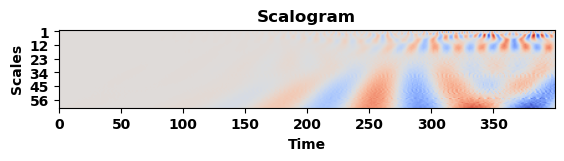

In [2]:
# Read a sample file
filename = os.path.dirname(os.getcwd()) + "/data/raw/cv_delta/clips/common_voice_en_34925857.mp3"

# Read an audio file using librosa
y, sr = librosa.load(filename)

wavelet = 'morl' # wavelet type: morlet
sr = 8000 # sampling frequency: 8KHz
widths = np.arange(1, 64) # scales for morlet wavelet 
print("These are the scales that we are using: ", widths)
dt = 1/sr # timestep difference

frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
print("These are the frequencies that re associated with the scales: ", frequencies)

# Compute continuous wavelet transform of the audio numpy array
wavelet_coeffs, freqs = pywt.cwt(y, widths, wavelet = wavelet, sampling_period=dt)
print("Shape of wavelet transform: ", wavelet_coeffs.shape)

# Display the scalogram. We will display a small part of scalogram because the length of scalogram is too big.
plt.imshow(wavelet_coeffs[:,:400], cmap='coolwarm')
plt.xlabel("Time")
plt.ylabel("Scales")
plt.yticks(widths[0::11])
plt.title("Scalogram")
plt.show()

These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130.
  127.45098039  125.          122.641509

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

Shape of wavelet transform:  (63, 106370)
These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130

KeyboardInterrupt: 

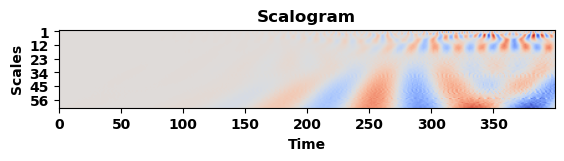

In [5]:
# The data in the current directory inside the doler "recordings".
dir = os.path.dirname(os.getcwd()) + "/data/raw/cv_delta/AIclips"
dest= os.path.dirname(os.getcwd()) + "/data/raw/cv_delta/scales/ai"
# Read audio files from the directory. For this tutorial, we will only classify 3 speakers: george, jackson, and lucas.
# Audio files have this format : {digit}_{speaker}_{speaker_filenumber}.wav

audio = [] # List to store audio np arrays
y = [] # List to store the target class labels

for root, dirs, files in os.walk(dir, topdown=False):    
    for name in files:

        if name.find(".mp3") != -1 : # Check if the file has a .wav extension            
            # Read an audio file using librosa
            y, sr = librosa.load(filename)

            wavelet = 'morl' # wavelet type: morlet
            sr = 8000 # sampling frequency: 8KHz
            widths = np.arange(1, 64) # scales for morlet wavelet 
            print("These are the scales that we are using: ", widths)
            dt = 1/sr # timestep difference
            new_name = name.split("/")[-1].replace(".mp3",".png")
            frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
            print("These are the frequencies that re associated with the scales: ", frequencies)

            # Compute continuous wavelet transform of the audio numpy array
            wavelet_coeffs, freqs = pywt.cwt(y, widths, wavelet = wavelet, sampling_period=dt)
            print("Shape of wavelet transform: ", wavelet_coeffs.shape)

            # Display the scalogram. We will display a small part of scalogram because the length of scalogram is too big.
            plt.imshow(wavelet_coeffs[:,:400], cmap='coolwarm')
            plt.xlabel("Time")
            plt.ylabel("Scales")
            plt.yticks(widths[0::11])
            plt.title("Scalogram")
            plt.savefig(os.path.join(dest, new_name))   

In [ ]:
def plot_im(image, dpi=300):
    px,py = image.shape # depending of your matplotlib.rc you may 
         #have to use py,px instead
    #px,py = im[:,:,0].shape # if image has a (x,y,z) shape 
    size = (10*py/np.float(dpi), 10*px/np.float(dpi)) # note the np.float()

    fig = plt.figure(figsize=size, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    # Customize the axis
    # remove top and right spines
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    # turn off ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.imshow(image, cmap='coolwarm')
    ax.set_aspect('auto')
    ax.set_box_aspect(1)
    plt.savefig(os.path.join(dest, 'new_plt.png'), bbox_inches = 'tight')
    plt.show()
     
    plt.close()
    
plot_im(wavelet_coeffs[:,80:800])